# Configurations

In [2]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'axes.linewidth': 1,
      'axes.labelpad': 6,
      'xtick.major.pad': 10,
      'xtick.major.width': 1,
      'ytick.major.width': 1,
      'lines.linewidth': 1,
      'font.size': 12,
      'axes.titlesize': 12,
      'axes.labelsize': 12,
      'xtick.labelsize': 12,
      'ytick.labelsize': 12,
      'legend.title_fontsize': 11,
      'legend.fontsize': 11,
      'figure.titlesize': 12,
      'figure.dpi': 72 * 3,
      'savefig.dpi': 72 * 4
      }
mpl.rcParams.update(rc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures', 'sfp_model', 'results_1D')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [4]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
lr = 0.005
max_epoch = 8000

nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
voxels='pRFcenter'

# eccentricity bin information
e1, e2=0.5, 4
enum=7
enum_range=range(7) if enum==7 else range(3) 
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:][::-1]
ecc_colors = dict(zip(bin_labels, ecc_colors))

# Load the data and model parameters

In [5]:
f, m = [], []
for subj, roi in itertools.product(nsd_subj_list[5:6], roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-{enum}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))

nsd_subj_df = utils.load_dataframes(f)
nsd_subj_df = nsd_subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(nsd_subj_list[5:6], roi_list, enum_range, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
nsd_tuning_df = tuning.load_all_models(pt_file_list, *args)

In [6]:
f, m = [], []
for subj, roi in itertools.product(broderick_subj_list[0:1], ['V1']):
    file_name = f'tfunc-corrected_e1-1_e2-12_nbin-11_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'broderick', 'binned', file_name))

broderick_subj_df = utils.load_dataframes(f)
broderick_subj_df = broderick_subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(broderick_subj_list[0:1], ['V1'], range(11), ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'tfunc-corrected_model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-1_e2-12_nbin-11_curbin-{curbin}_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'broderick', file_name))
    
broderick_tuning_df = tuning.load_all_models(pt_file_list, *args)

In [7]:
nsd_subj_df['dset'] = 'nsdsyn'
broderick_subj_df['dset'] = 'broderick'
nsd_tuning_df['dset'] = 'nsdsyn'
broderick_tuning_df['dset'] = 'broderick'
final_subj_df = pd.concat((nsd_subj_df, broderick_subj_df), axis=0)
final_tuning_df = pd.concat((nsd_tuning_df, broderick_tuning_df), axis=0)

# Normalize

In [8]:
# Define the normalization function
def normalize(group):
    min_val = group.min()
    max_val = group.max()
    return (group - min_val) / (max_val - min_val)

# Group by the specified columns and apply the normalization to 'betas'
nsd_subj_df['normalized_betas'] = nsd_subj_df.groupby(['sub', 'ecc_bin', 'vroinames','dset'])['betas'].transform(normalize)
broderick_subj_df['normalized_betas'] = broderick_subj_df.groupby(['sub', 'ecc_bin', 'vroinames','dset'])['betas'].transform(normalize)


# Plot tuning curves

In [9]:
a = [3, 2, 0]
pal = [sns.color_palette('dark', 10)[:][k] for k in a]
stim_class = 'avg'
bins_to_plot = [bin_labels[k] for k in [0, -1]]
bins_to_plot_broderick = ['2.0-3.0 deg','9.0-10.0 deg']

(<Figure size 1512x540 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Broderick et al.\n(2022)'}>,
        <AxesSubplot:title={'center':'NSD V1'}>,
        <AxesSubplot:title={'center':'NSD V2'}>,
        <AxesSubplot:title={'center':'NSD V3'}>], dtype=object))

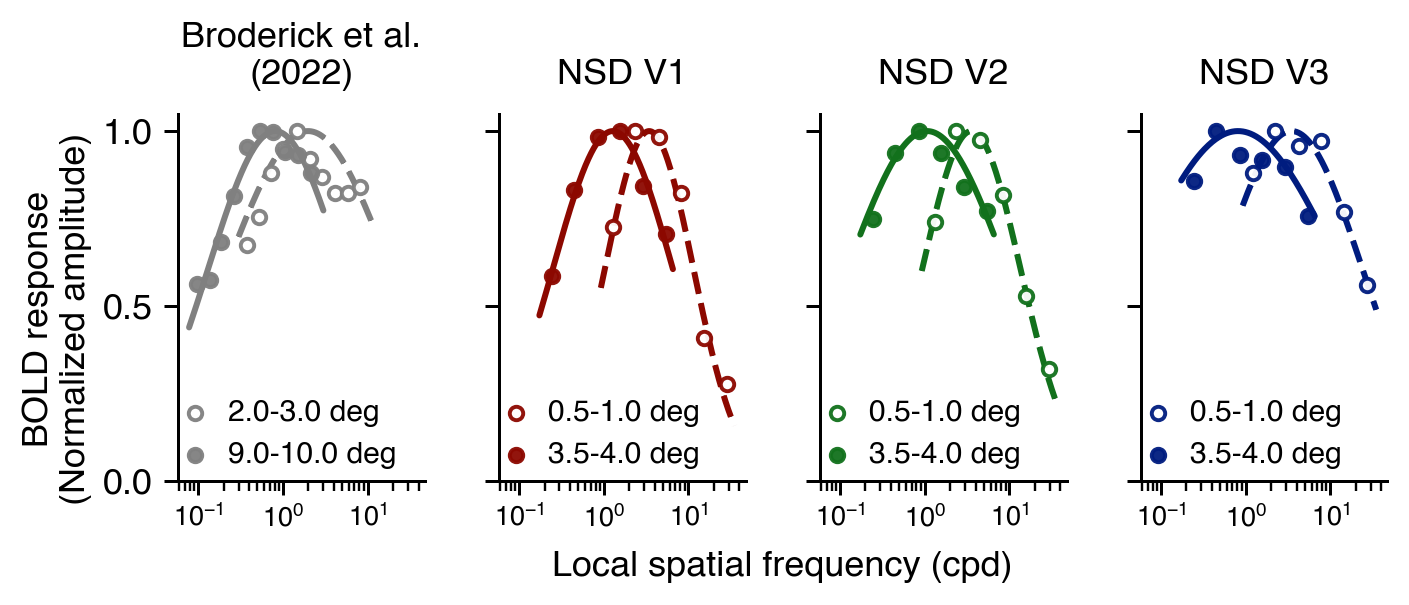

In [85]:
vis1D.plot_sf_curves_with_broderick('subj06', nsd_subj_df, nsd_tuning_df, bins_to_plot, 
                                    'wlsubj001', broderick_subj_df, broderick_tuning_df, bins_to_plot_broderick, 
                                    pal, save_path=os.path.join(fig_dir, 'all', 'tuning_class-avg_lr-0.005_eph-8000_e1-0.5_e2-4_nbin-7_vs-pRFcenter.svg'))

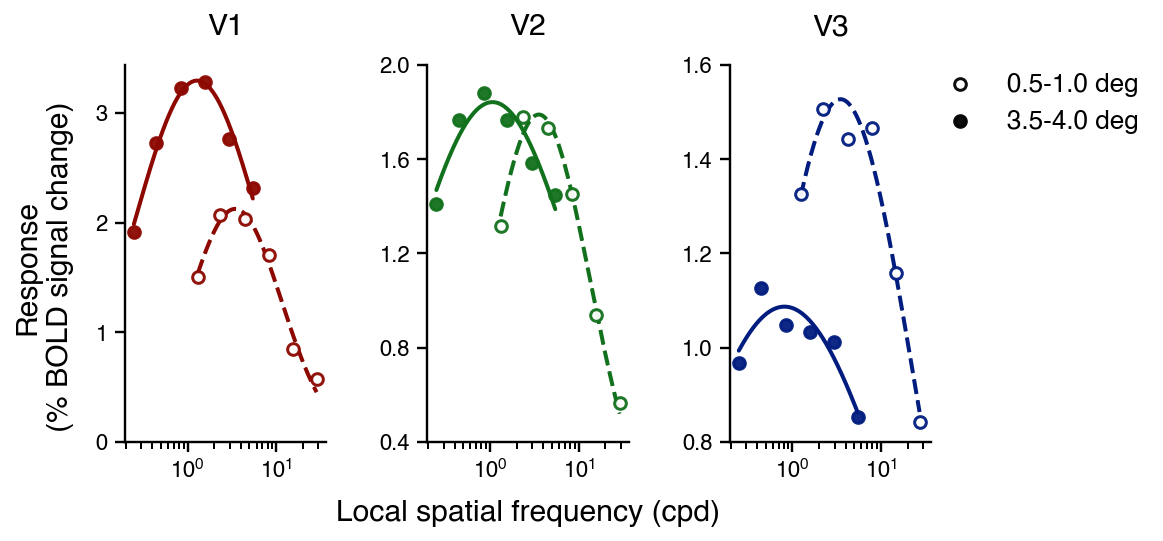

In [29]:
a = [3, 2, 0]
pal = [sns.color_palette('dark', 10)[:][k] for k in a]

bins_to_plot = [bin_labels[k] for k in [0,-1]]
stim_class = 'avg'
tmp_subj_df = final_subj_df.query('sub == "subj06"')
tmp_tuning_df = final_tuning_df.query('sub == "subj06" & names == @stim_class')
fig_name = os.path.join(output_dir,"figures", "sfp_model","results_1D", "nsdsyn", f'tuning_class_{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-all_dset-nsdsyn_sub-subj06_roi-all_vs-pRFsize.pdf')
g = vis1D.plot_sf_curves(df=tmp_subj_df, x='local_sf', y='betas', hue='ecc_bin', hue_order=bins_to_plot,
                         col='vroinames', params_df=tmp_tuning_df, lgd_title=None, palette=pal,
                         save_path=None)

# Plot preferred period as function of eccentricity

## Load in precision data

### NSD Precision data

In [93]:
file_list = []
for subj, roi in itertools.product(nsd_subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 
                     f'precision-v_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
    
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

### NSD Load in the fitting results and calculate the preferred period

In [95]:

# eccentricity bin information
e1, e2=0.5, 4
enum=7
enum_range=range(7) if enum==7 else range(3) 
nsd_bin_list, nsd_bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)

args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(nsd_subj_list, roi_list, enum_range, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
nsd_tuning_df = tuning.load_all_models(pt_file_list, *args)

nsd_tuning_with_precision_df = nsd_tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
nsd_tuning_with_precision_df['pp'] = 1/ nsd_tuning_with_precision_df['mode']
nsd_fit_df = vis1D.fit_line_to_weighted_mean(nsd_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

### Broderick precision data

In [97]:
f, m = [], []
dset = 'broderick'
tfunc = 'corrected'
voxels = 'pRFcenter'

broderick_subj_list = [utils.sub_number_to_string(sn, dataset="broderick") for sn in [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]]
e1='1'
e2='12'
enum=11
broderick_bin_list, broderick_bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)

enum_range=np.arange(0,11)
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']

In [98]:
file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    f = os.path.join(output_dir, 'dataframes', 'broderick', 'precision', 
                     f'precision-v_dset-broderick_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
    
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

In [99]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(broderick_subj_list, ['V1'], enum_range, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'tfunc-corrected_model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'broderick', file_name))
tuning_df = tuning.load_all_models(pt_file_list, *args)

broderick_tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
broderick_tuning_with_precision_df['pp'] = 1/ broderick_tuning_with_precision_df['mode']
broderick_fit_df = vis1D.fit_line_to_weighted_mean(broderick_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

In [112]:
broderick_tuning_with_precision_df['dset_type'] = 'Broderick et al. V1'
broderick_fit_df['dset_type'] = 'Broderick et al. V1'
broderick_tuning_with_precision_df['goal'] = 'Replication'
broderick_fit_df['goal'] = 'Replication'

nsd_tuning_with_precision_df['dset_type'] = nsd_tuning_with_precision_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_fit_df['dset_type'] = nsd_fit_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_tuning_with_precision_df['goal'] = nsd_tuning_with_precision_df['vroinames'].apply(lambda x: 'Replication' if x == 'V1' else 'Extension')
nsd_fit_df['goal'] = nsd_fit_df['vroinames'].apply(lambda x: 'Replication' if x == 'V1' else 'Extension')

tmp = nsd_tuning_with_precision_df.query('vroinames == "V1"')
tmp['goal'] = 'Extension'
nsd_tuning_with_precision_df = pd.concat((tmp, nsd_tuning_with_precision_df), axis=0)

tmp = nsd_fit_df.query('vroinames == "V1"')
tmp['goal'] = 'Extension'
nsd_fit_df = pd.concat((tmp, nsd_fit_df), axis=0)

tuning_with_precision_df = pd.concat((broderick_tuning_with_precision_df, 
                                      nsd_tuning_with_precision_df), axis=0)
fit_df = pd.concat((broderick_fit_df, nsd_fit_df), axis=0)

## Plot

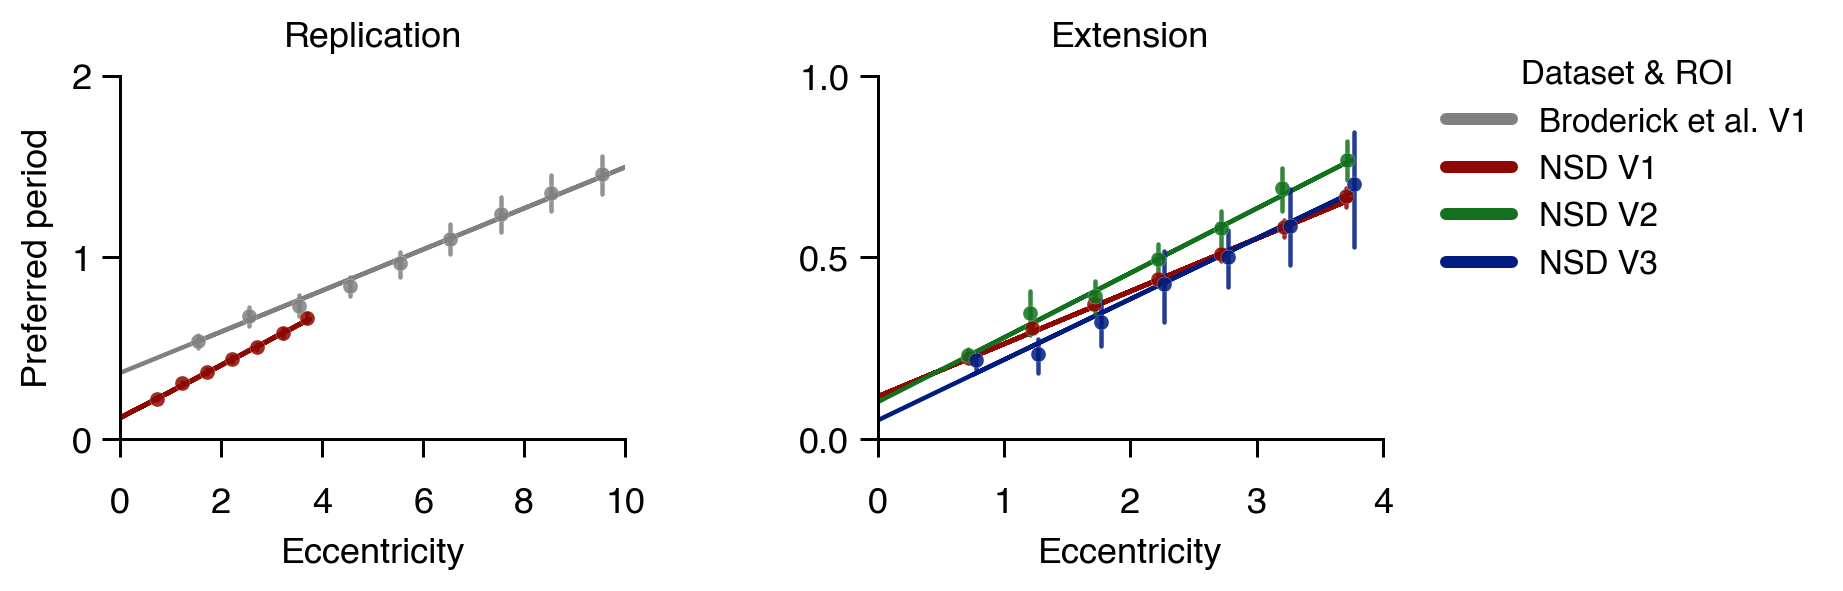

In [127]:
a = [3,2,0]
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
roi_pal.insert(0, (0.5,0.5,0.5))

g = vis1D.plot_preferred_period(tuning_with_precision_df, fit_df=fit_df, 
                                col='goal', col_order=['Replication','Extension'], 
                                preferred_period='pp', precision='precision', hue='dset_type', 
                                hue_order=['Broderick et al. V1', 'NSD V1','NSD V2','NSD V3'], lgd_title='Dataset & ROI',
                                pal=roi_pal,
                                save_path=os.path.join(fig_dir, 'all', 'rep-ext-pperiod_class-avg_lr-0.005_eph-8000_e1-0.5_e2-4_nbin-7_vs-pRFcenter.svg'))

# Plot Bandwidth as function of eccentricity

In [128]:
tuning_with_precision_df['fwhm'] = tuning_with_precision_df['sigma']*2.335
fit_bandwidth_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'fwhm', 'precision', groupby=['dset_type','goal'])

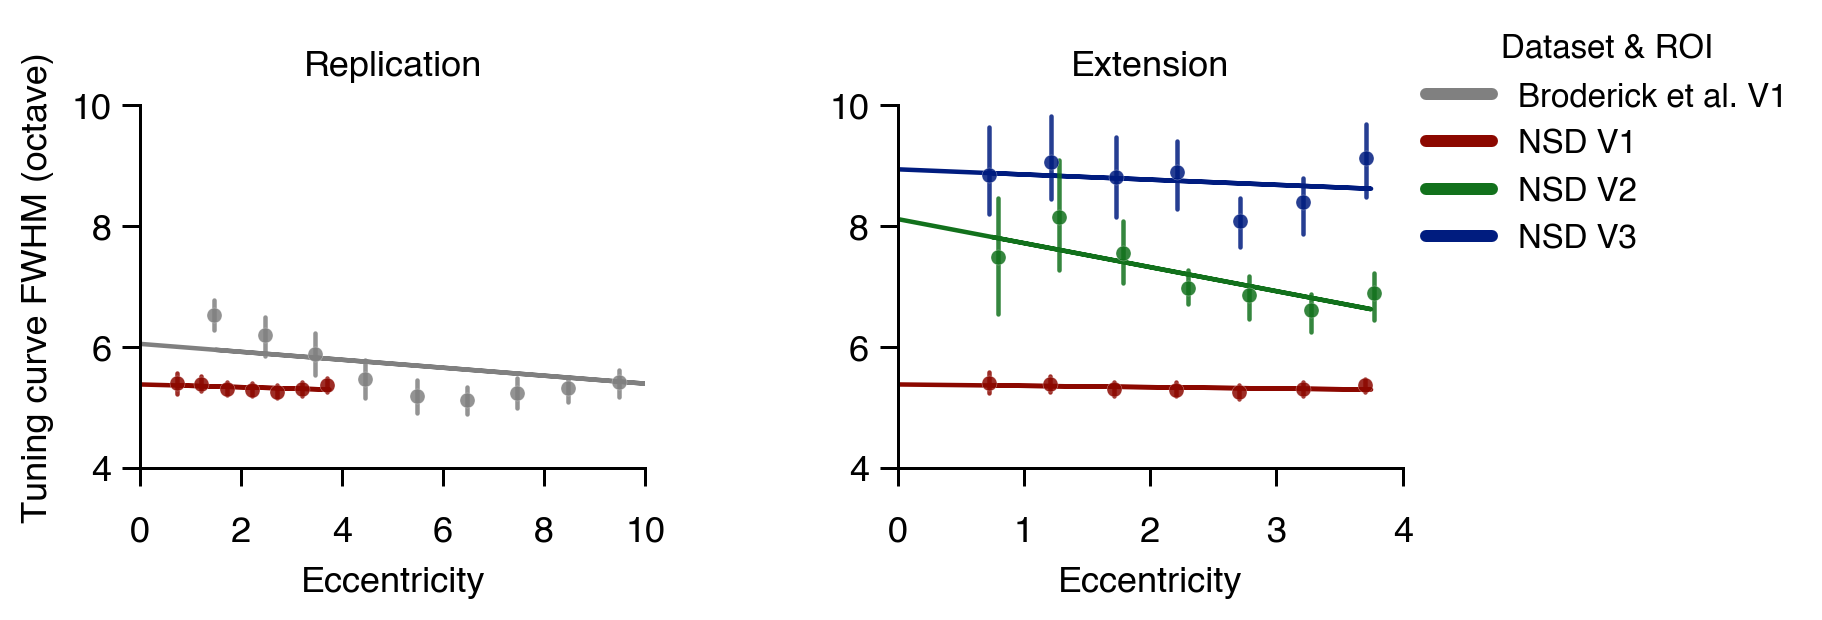

In [139]:
vis1D.plot_bandwidth_in_octave(df=tuning_with_precision_df, fit_df=fit_bandwidth_df,
                               bandwidth='fwhm', precision='precision', 
                               col='goal', col_order=['Replication','Extension'], 
                               hue='dset_type', 
                                hue_order=['Broderick et al. V1', 'NSD V1','NSD V2','NSD V3'], lgd_title='Dataset & ROI',
                                pal=roi_pal,
                               save_path=os.path.join(fig_dir, 'all', 'rep-ext-bandwidth_class-avg_lr-0.005_eph-8000_e1-0.5_e2-4_nbin-7_vs-pRFcenter.svg'))

## Plot Broderick et al's data together

In [88]:
f, m = [], []
dset = 'broderick'
tfunc = 'corrected'
voxels = 'pRFcenter'

broderick_subj_list = [utils.sub_number_to_string(sn, dataset="broderick") for sn in [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]]
e1='1'
e2='12'
enum=11
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)

enum_range=np.arange(0,11)
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
lr = 0.005
max_epoch = 8000

In [89]:
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = f'tfunc-{tfunc}_e1-{e1}_e2-{e2}_nbin-{enum}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', dset, 'binned', file_name))

subj_df = utils.load_dataframes(f)
subj_df = subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(broderick_subj_list, ['V1'], enum_range, stim_classes+['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'tfunc-{tfunc}_model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', dset, file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

KeyboardInterrupt: 

In [49]:
roi_pal

[(0.5490196078431373, 0.03137254901960784, 0.0),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.0, 0.10980392156862745, 0.4980392156862745)]

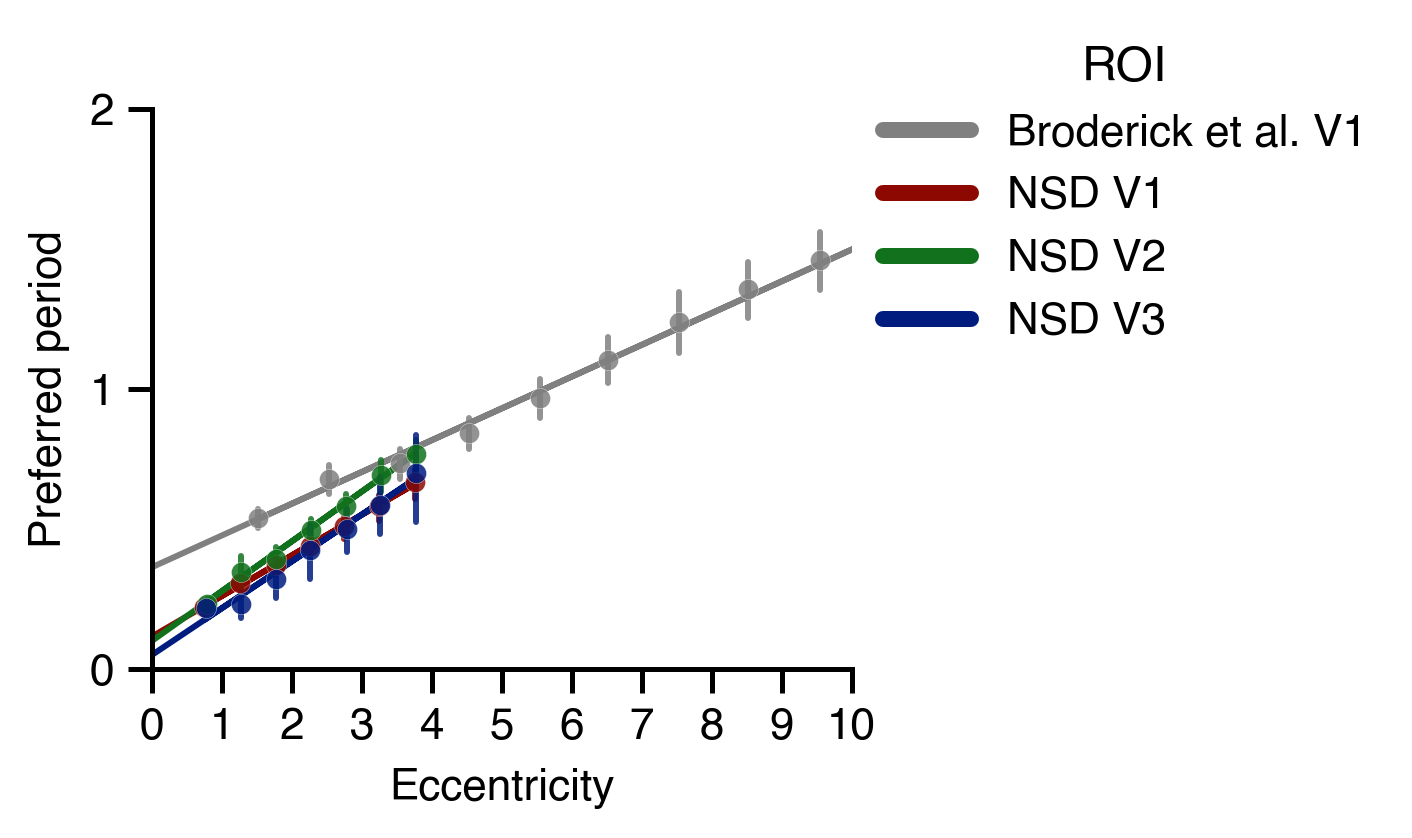

In [102]:
a = [3,2,0]

roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
roi_pal.insert(0, (0.5,0.5,0.5))
g = vis1D.plot_preferred_period(tuning_with_precision_df, fit_df=fit_df, 
                                preferred_period='pp', precision='precision', hue='dset_type', 
                                hue_order=['Broderick et al. V1',
                                           'NSD V1', 'NSD V2','NSD V3'], lgd_title='ROI',
                                pal=roi_pal,
                                save_path=None)

In [96]:
tuning_with_precision_df['fwhm'] = tuning_with_precision_df['sigma'] * 2.335 
fit_bandwidth_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df,'fwhm','precision',groupby=['vroinames','dset_type'])


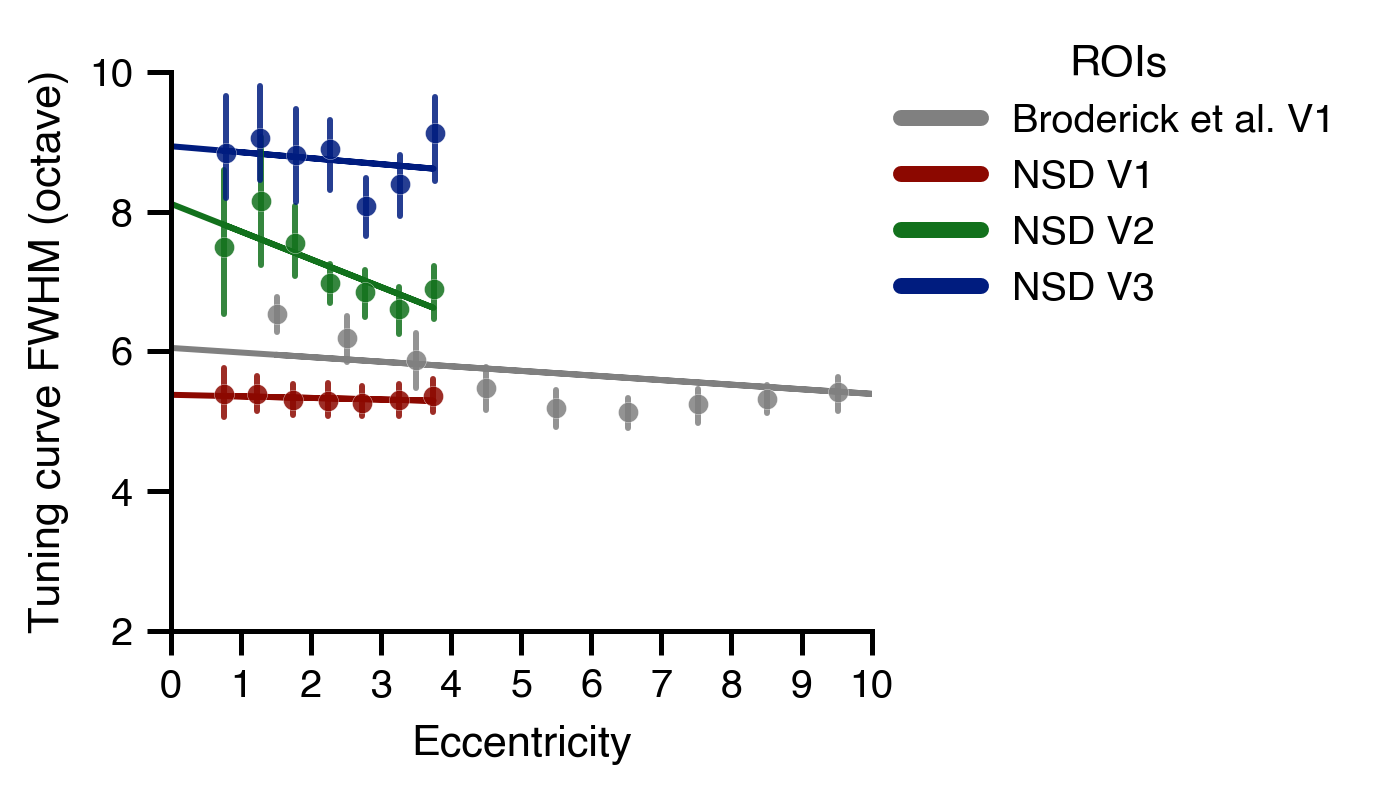

In [101]:
vis1D.plot_bandwidth_in_octave(tuning_with_precision_df, 
                               bandwidth='fwhm', precision='precision', 
                               hue='dset_type', hue_order=['Broderick et al. V1',
                                           'NSD V1', 'NSD V2','NSD V3'], 
                               fit_df=fit_bandwidth_df,
                               pal=roi_pal,
                               lgd_title='ROIs',
                               col=None, col_order=None,
                               suptitle=None, width=3.25, errorbar=("ci", 68),
                               save_path=None)